In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
# Replace 'new_directory_path' with the path of the directory you want to set as the working directory
new_directory_path = r'/Users/seanbastians/Desktop/UNIVERSITY/4th Year/FIT3162 - DataSci Project 2/Project Files/fit3164_ds16/Datasets/Clean Datasets'

# Change the working directory
os.chdir(new_directory_path)

# Replace 'your_file.xls' with the actual path to your Excel file
excel_file_path = 'Forecasting-data.xlsx'

# Read the Excel file into a pandas DataFrame
df = pd.read_excel(excel_file_path)
df.set_index('Quarter')
df.index = pd.to_datetime(df.index)

fnab_df = df[['Quarter', 'FNAB']]
fnab_df = fnab_df.set_index('Quarter')
fnab_df.index = pd.to_datetime(fnab_df.index)
print(fnab_df.tail())

agcpi_df = df[['Quarter', 'AGCPI']]
agcpi_df = agcpi_df.set_index('Quarter')
agcpi_df.index = pd.to_datetime(agcpi_df.index)
print(agcpi_df.tail())

            FNAB
Quarter         
2022-06-01   5.9
2022-09-01   9.0
2022-12-01   9.2
2023-03-01   8.0
2023-06-01   7.5
            AGCPI
Quarter          
2022-06-01    1.8
2022-09-01    1.8
2022-12-01    1.9
2023-03-01    1.4
2023-06-01    0.8


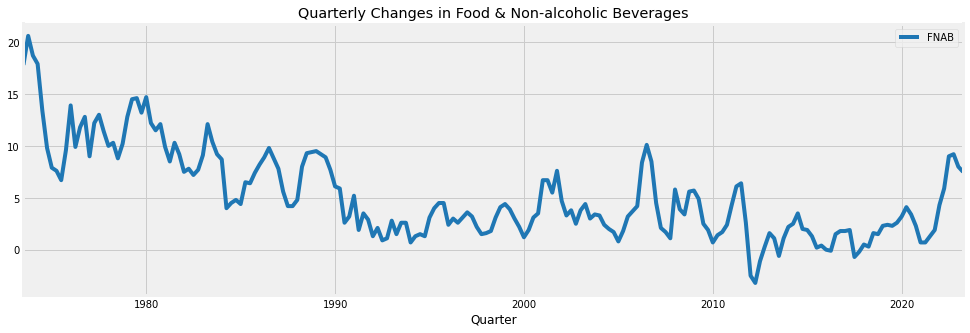

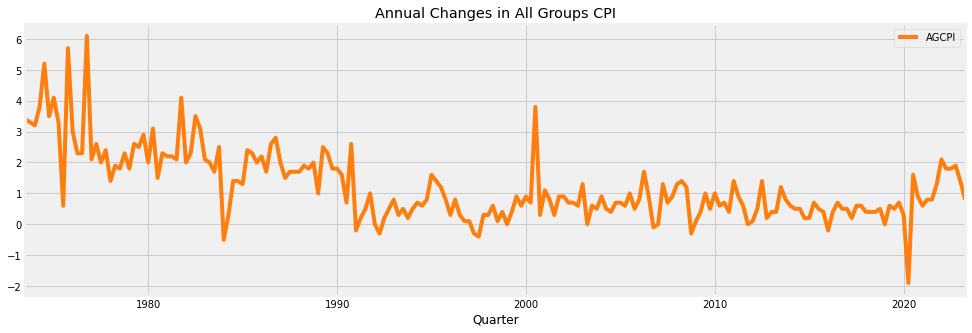

In [3]:
fnab_df.plot(style='-',
        figsize=(15, 5),
        color=color_pal[0],
        title='Quarterly Changes in Food & Non-alcoholic Beverages')
plt.show()

agcpi_df.plot(style='-',
        figsize=(15, 5),
        color=color_pal[1],
        title='Annual Changes in All Groups CPI')
plt.show()

# FNAB

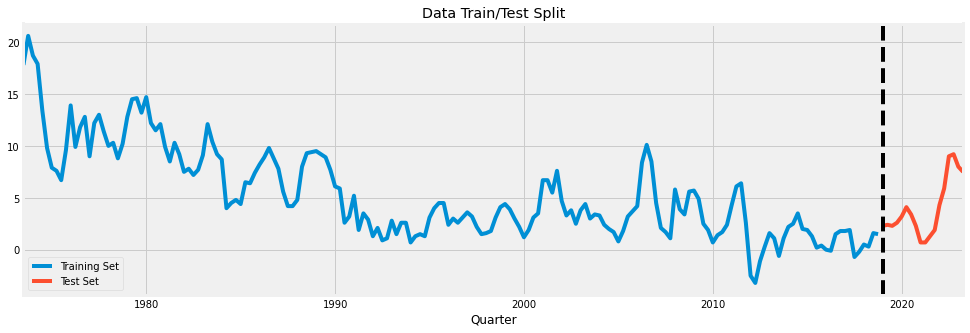

In [4]:
# FNAB Train / Test Split
train = fnab_df.loc[fnab_df.index < '01-06-2019']
test = fnab_df.loc[fnab_df.index >= '01-06-2019']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-06-2019', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [5]:
# Feature Creation 
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    return df

fnab_df = create_features(fnab_df)
fnab_df.head()


,FNAB,quarter,month,year
Quarter,,,,
1973-09-01,17.8,3,9,1973
1973-12-01,20.6,4,12,1973
1974-03-01,18.7,1,3,1974
1974-06-01,17.9,2,6,1974
1974-09-01,13.4,3,9,1974


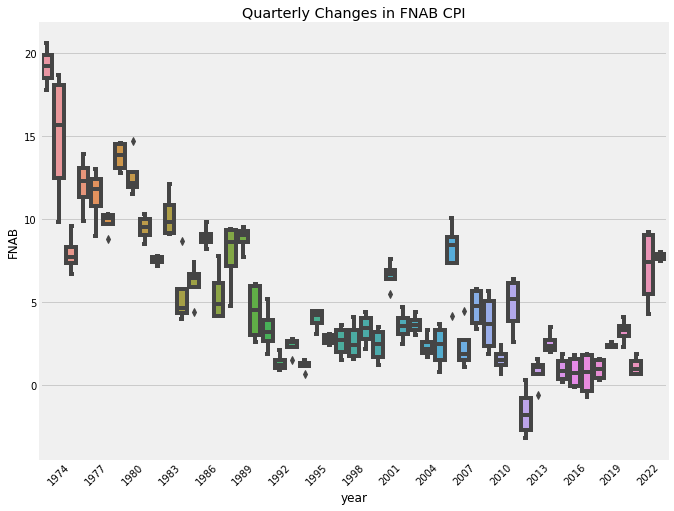

In [6]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=fnab_df, x='year', y='FNAB')
ax.set_title('Quarterly Changes in FNAB CPI')
# Set tick positions and labels manually
unique_years = sorted(fnab_df['year'].unique())
xtick_positions = [i for i, year in enumerate(unique_years) if year % 3 == 0]
xtick_labels = [year for year in unique_years if year % 3 == 0]

ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels, rotation=45)
plt.show()

In [7]:
# Create Model
train = create_features(train)
test = create_features(test)

FEATURES = ['quarter', 'month', 'year']
TARGET = 'FNAB'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

[0]	validation_0-rmse:6.42852	validation_1-rmse:4.37874


/opt/homebrew/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:15:41] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:3.02471	validation_1-rmse:4.09242
[200]	validation_0-rmse:1.97619	validation_1-rmse:3.92102
[300]	validation_0-rmse:1.65393	validation_1-rmse:3.88368
[337]	validation_0-rmse:1.59922	validation_1-rmse:3.89721


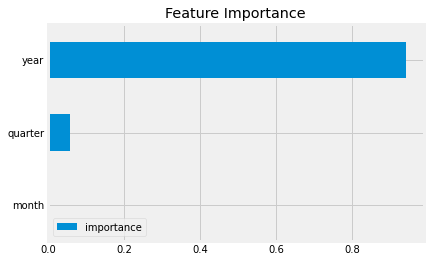

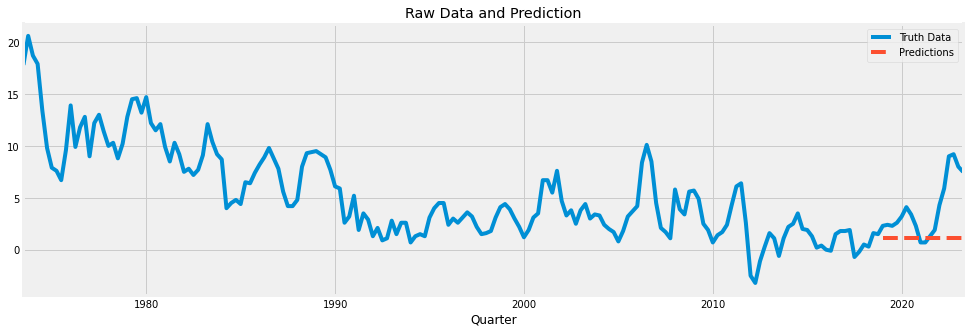

In [8]:
# Run Model using XG Boost
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

# Feature Importance
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Raw Data & Prediction
test['prediction'] = reg.predict(X_test)
fnab_df = fnab_df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = fnab_df[['FNAB']].plot(figsize=(15, 5))
fnab_df['prediction'].plot(ax=ax, style='--')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

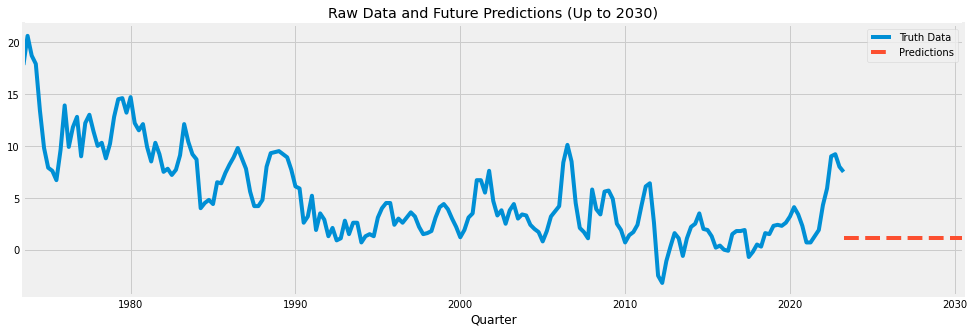

In [9]:
# Extend your DataFrame to include future dates up to 2030
future_dates = pd.date_range(start='06-01-2023', end='12-01-2030', freq='Q')
future_df = pd.DataFrame({'quarter': future_dates.quarter, 'month': future_dates.month, 'year': future_dates.year})

# Set the datetime index
future_df.set_index(future_dates, inplace=True)

# Preprocess the extended DataFrame
future_df = create_features(future_df)

# Run predictions on the extended dataset
future_predictions = reg.predict(future_df[FEATURES])

# Create a DataFrame for future predictions
future_df['prediction'] = future_predictions

# Plot the predictions for the future years
ax = fnab_df[['FNAB']].plot(figsize=(15, 5))
future_df['prediction'].plot(ax=ax, style='--')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Future Predictions (Up to 2030)')
plt.show()

# AGCPI

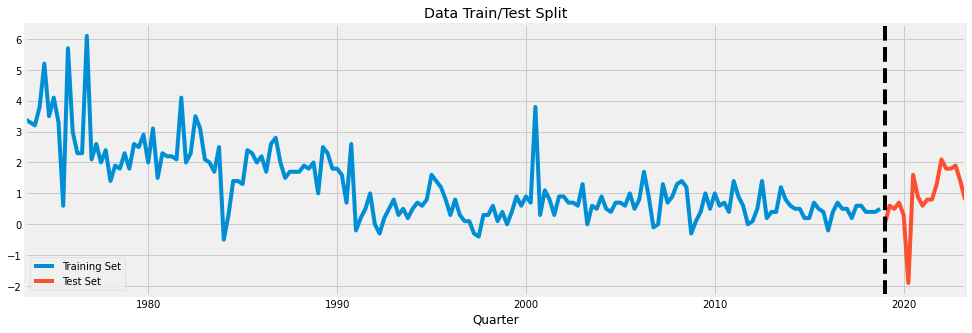

In [10]:
# FNAB Train / Test Split
train = agcpi_df.loc[agcpi_df.index < '01-06-2019']
test = agcpi_df.loc[agcpi_df.index >= '01-06-2019']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-06-2019', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [11]:
# Feature Creation 
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    return df

agcpi_df = create_features(agcpi_df)
agcpi_df.head()

,AGCPI,quarter,month,year
Quarter,,,,
1973-09-01,3.4,3,9,1973
1973-12-01,3.3,4,12,1973
1974-03-01,3.2,1,3,1974
1974-06-01,3.8,2,6,1974
1974-09-01,5.2,3,9,1974


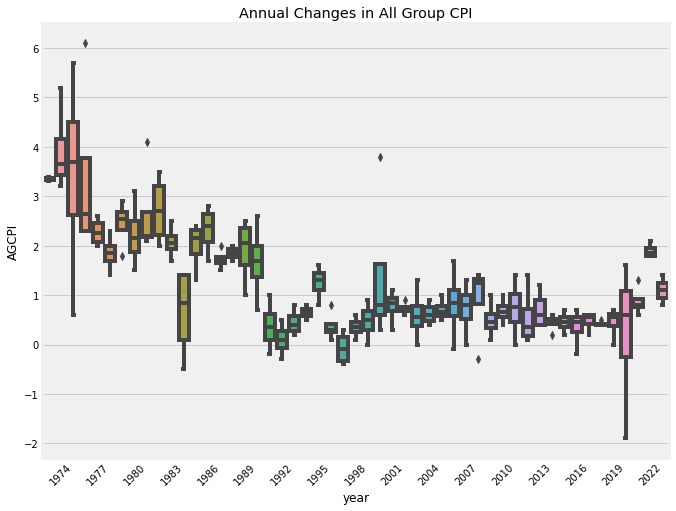

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=agcpi_df, x='year', y='AGCPI')
ax.set_title('Annual Changes in All Group CPI')
# Set tick positions and labels manually
unique_years = sorted(agcpi_df['year'].unique())
xtick_positions = [i for i, year in enumerate(unique_years) if year % 3 == 0]
xtick_labels = [year for year in unique_years if year % 3 == 0]

ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels, rotation=45)
plt.show()

In [13]:
# Create Model
train = create_features(train)
test = create_features(test)

FEATURES = ['quarter', 'month', 'year']
TARGET = 'AGCPI'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

[0]	validation_0-rmse:1.37142	validation_1-rmse:0.97420


/opt/homebrew/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:15:42] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:0.77658	validation_1-rmse:0.96740
[111]	validation_0-rmse:0.74320	validation_1-rmse:0.96830


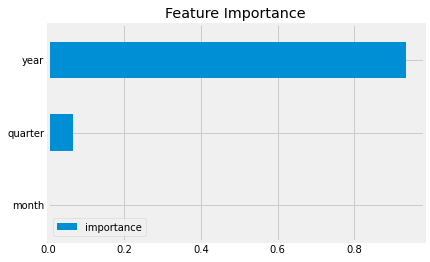

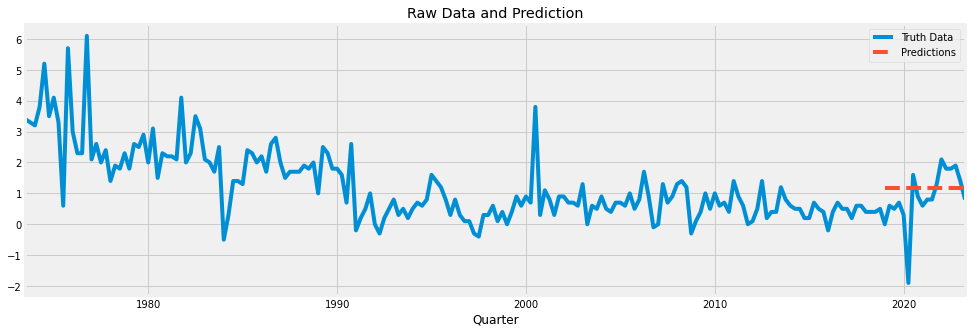

In [14]:
# Run Model using XG Boost
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

# Feature Importance
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Raw Data & Prediction
test['prediction'] = reg.predict(X_test)
agcpi_df = agcpi_df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = agcpi_df[['AGCPI']].plot(figsize=(15, 5))
fnab_df['prediction'].plot(ax=ax, style='--')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

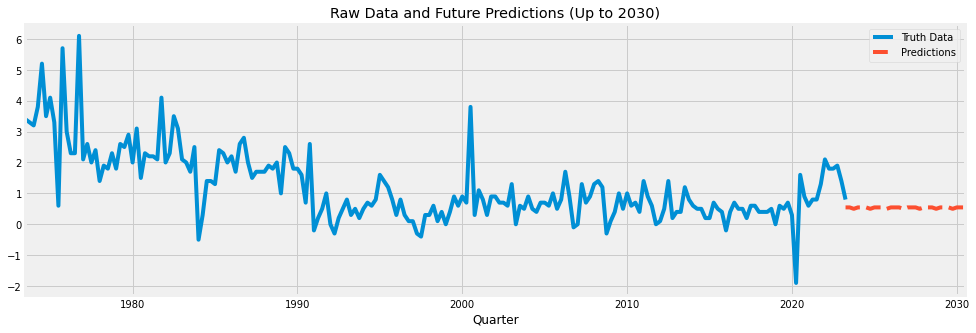

In [15]:
# Extend your DataFrame to include future dates up to 2030
future_dates = pd.date_range(start='06-01-2023', end='12-01-2030', freq='Q')
future_df = pd.DataFrame({'quarter': future_dates.quarter, 'month': future_dates.month, 'year': future_dates.year})

# Set the datetime index
future_df.set_index(future_dates, inplace=True)

# Preprocess the extended DataFrame
future_df = create_features(future_df)

# Run predictions on the extended dataset
future_predictions = reg.predict(future_df[FEATURES])

# Create a DataFrame for future predictions
future_df['prediction'] = future_predictions

# Plot the predictions for the future years
ax = agcpi_df[['AGCPI']].plot(figsize=(15, 5))
future_df['prediction'].plot(ax=ax, style='--')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Future Predictions (Up to 2030)')
plt.show()